сайт соревнования Semeval-2021 Task 2: [Multilingual and Cross-lingual Word-in-Context Disambiguation](https://competitions.codalab.org/competitions/27054)

In [ ]:
!git clone -q  https://github.com/DanilDmitriev1999/ABBYY_HW_NLP

In [ ]:
!pip install --upgrade -r /content/ABBYY_HW_NLP/WiC/requirements.txt

     |████████████████████████████████| 7.0MB 7.7MB/s 
     |████████████████████████████████| 12.8MB 248kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 696kB 47.2MB/s 
     |████████████████████████████████| 2.3MB 39.2MB/s 
     |████████████████████████████████| 1.2MB 47.7MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 266kB 53.8MB/s 
     |████████████████████████████████| 112kB 57.6MB/s 
     |████████████████████████████████| 829kB 57.2MB/s 
     |████████████████████████████████| 276kB 49.8MB/s 
     |████████████████████████████████| 901kB 46.5MB/s 
     |████████████████████████████████| 3.3MB 42.2MB/s 
     |████████████████████████████████| 522kB 53.5MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 1.3MB 43.5MB/s 
     |████████████████████████████████| 296kB 52.7MB

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import comet_ml

import os
import torch
import random
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch import nn
from torch.nn import functional as F

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.metrics import Accuracy
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import EarlyStopping  
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup, AutoModel
from transformers import BertTokenizerFast


comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
from ABBYY_HW_NLP.WiC.DataModule.custom_dataset import *
from ABBYY_HW_NLP.WiC.DataModule.utils import *

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Скачиваем данные с гитхаба соревнования

In [ ]:
!mkdir data && git clone https://github.com/SapienzaNLP/mcl-wic.git data && cd data && unzip 'SemEval-2021_MCL-WiC_all-datasets.zip'  && mv 'SemEval-2021_MCL-WiC_test-gold-data.zip' 'MCL-WiC/test' && cd MCL-WiC/test && unzip 'SemEval-2021_MCL-WiC_test-gold-data.zip' && rm *.zip && cd ../.. && rm *.zip && ls


Cloning into 'data'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 188 (delta 41), reused 0 (delta 0), pack-reused 96
Receiving objects: 100% (188/188), 7.59 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Archive:  SemEval-2021_MCL-WiC_all-datasets.zip
   creating: MCL-WiC/
   creating: MCL-WiC/training/
  inflating: MCL-WiC/training/training.en-en.data  
  inflating: MCL-WiC/training/training.en-en.gold  
  inflating: MCL-WiC/README.txt      
   creating: MCL-WiC/test/
   creating: MCL-WiC/test/crosslingual/
  inflating: MCL-WiC/test/crosslingual/test.en-ar.data  
  inflating: MCL-WiC/test/crosslingual/test.en-zh.data  
  inflating: MCL-WiC/test/crosslingual/test.en-ru.data  
  inflating: MCL-WiC/test/crosslingual/test.en-fr.data  
   creating: MCL-WiC/test/multilingual/
  inflating: MCL-WiC/test/multilingual/test.fr-fr.data  
  inflating: MCL-WiC/test/multilingual/

In [ ]:
df_train_wic = read_train_data('data/MCL-WiC/training/training.en-en.data', True)
df_dev_wic = read_train_data('data/MCL-WiC/dev/multilingual/dev.en-en.data', True)
df_test_wic = read_train_data('data/MCL-WiC/test/multilingual/test.en-en.data', True)
print(df_train_wic.shape)
print(df_dev_wic.shape)
print(df_test_wic.shape)
print(df_train_wic.head())
print(df_dev_wic.head())
print(df_test_wic.head())

(8000, 10)
(1000, 10)
(1000, 10)
                 id   lemma   pos  ... start2 end2 tag
0  training.en-en.0    play  NOUN  ...     10   14   0
1  training.en-en.1    play  NOUN  ...    112  116   0
2  training.en-en.2  esteem  NOUN  ...    106  112   1
3  training.en-en.3  esteem  NOUN  ...     20   26   1
4  training.en-en.4  holder  NOUN  ...     27   33   1

[5 rows x 10 columns]
            id         lemma   pos  ... start2 end2 tag
0  dev.en-en.0      superior  NOUN  ...     41   50   0
1  dev.en-en.1      superior  NOUN  ...     44   53   1
2  dev.en-en.2  acquaintance  NOUN  ...     41   54   0
3  dev.en-en.3  acquaintance  NOUN  ...     74   86   0
4  dev.en-en.4       baggage  NOUN  ...      6   13   1

[5 rows x 10 columns]
             id   lemma   pos  ... start2 end2 tag
0  test.en-en.0  gently   ADV  ...     59   65   0
1  test.en-en.1  gently   ADV  ...     72   78   0
2  test.en-en.2    next   ADJ  ...     85   89   1
3  test.en-en.3    next   ADJ  ...     84   88   1


### Разбиваем по леммам

In [ ]:
global_df = pd.concat([df_train_wic, df_dev_wic], ignore_index=True)
df_train, df_val = lemma_train_test_split(global_df)

df_test = df_test_wic
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


(7176, 10)
(1824, 10)
(1000, 10)


In [ ]:
train_labels = df_train["tag"].tolist()
val_labels = df_val["tag"].tolist()
test_labels = df_test["tag"].tolist()

train_sentences = [(s1, s2) for s1, s2 in zip(df_train["sentence1"], df_train["sentence2"])]
val_sentences = [(s1, s2) for s1, s2 in zip(df_val["sentence1"], df_val["sentence2"])]
test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

train_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_train["start1"], df_train["end1"], df_train["start2"], df_train["end2"])]
val_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_val["start1"], df_val["end1"], df_val["start2"], df_val["end2"])]
test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

print(train_sentences[0])
print(train_word_ranges[0])

('We would also like to convey our esteem and congratulations to fraternal Lebanon and its people on the unconditional liberation of its southern part.', 'Father Lini said that, because of that, the United Nations has a very special place in the affections and esteem of the people of Vanuatu.')
((33, 39), (106, 112))


### Готовим Dataset и Dataloader

In [ ]:
INDICES_PADDING_LEN = 5
INDICES_PADDING_VALUE = 0
MAX_TOKENS = 100
BATCH_SIZE = 8
EPOCHS = 5

In [ ]:
mbert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

In [ ]:
train_data = BertDataset(train_sentences, train_word_ranges, train_labels, MAX_TOKENS, mbert_tokenizer)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = BertDataset(val_sentences, val_word_ranges, val_labels, MAX_TOKENS, mbert_tokenizer)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = BertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)


In [ ]:
len(test_loader)

125

In [ ]:
def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out

def get_mask(indices, embedding_size):
    mask = (indices != INDICES_PADDING_VALUE)
    mask.unsqueeze_(-1)
    mask = mask.expand(mask.shape[0], mask.shape[1], embedding_size)
    LARGE_VALUE = 2**32
    return torch.where(mask == True, 0, LARGE_VALUE)

def get_tokens_embeddings(batch, indices):
    return batched_index_select(batch, 1, indices) - get_mask(indices, batch.shape[2])


### используйте косинусную близость вместо линейных слоев для определения, имеют ли таргет-слова одно значение или разные

In [ ]:
comet_logger = CometLogger(
    api_key="HWfJT3eyByVJWe4nEbi1pGosA",
    workspace="danildmitriev1999",
    project_name="3-sem",
    experiment_name="Multilingual all layers BERT with CosSim, RELU",
)

CometLogger will be initialized in online mode


In [ ]:
model = BertModel.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True, output_attentions=True)
test_batch = next(iter(train_loader))
inputs, attn, word_indices, labels = test_batch

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_output = model(inputs[0], attn[0])

In [ ]:
test_output['hidden_states']

13

In [ ]:
pooled_output = torch.cat(tuple([test_output['hidden_states'][i] for i in [5, 6, 7, 8, 9, 10, 11, 12]]), dim=-1)

In [ ]:
pooled_output.shape

torch.Size([8, 100, 6144])

In [ ]:
test_output['pooler_output'].shape

torch.Size([8, 768])

In [ ]:
tokens_embeddings = get_tokens_embeddings(pooled_output, word_indices[0])
word_embedding = torch.max(tokens_embeddings, 1)[0]

In [ ]:
word_embedding.shape

torch.Size([8, 6144])

In [ ]:
class CosSimNLayersClassifier(LightningModule):
    def __init__(self, model_path):
        super(CosSimNLayersClassifier, self).__init__()

        self.model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True)
        self.embedding_dim = self.model.get_input_embeddings().embedding_dim

        self.loss = nn.BCELoss()
        self.save_hyperparameters()

        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
        self.predictions_proba = torch.Tensor()

        # self.input_dim = 2 * self.embedding_dim
        # self.linear = nn.Linear(self.input_dim, 10)
        # self.final_linear = nn.Linear(10, 1)

        self.relu = nn.ReLU()
        # self.relu = nn.ReLU()

        self.cos_sim = nn.CosineSimilarity()

        self.predictions_proba = []

        self.threshold = 0.5

        self.lang = 'en->en'
        self.n_layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    
    def _get_hidden_state(self, input_ids, attention_mask):
        tr_output = self.model(input_ids, attention_mask)
        pooled_output = torch.cat(tuple([tr_output['hidden_states'][i] for i in self.n_layers]), dim=-1)
        return pooled_output

    def _get_embeddings(self, input_ids, attention_mask, word_indices):
        sentence_outputs = self._get_hidden_state(input_ids, attention_mask)
        tokens_embeddings = get_tokens_embeddings(sentence_outputs, word_indices)
        word_embedding = torch.max(tokens_embeddings, 1)[0]
        return word_embedding

    def forward(self, input_ids, attention_mask, word_indices):
        first_embeddings = self._get_embeddings(input_ids[0], attention_mask[0], word_indices[0])
        second_embeddings = self._get_embeddings(input_ids[1], attention_mask[1], word_indices[1])

        outputs = self.cos_sim(first_embeddings, second_embeddings)
        outputs = self.relu(outputs)
        return outputs    

    def training_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)
        return self.loss(outputs, labels)

    def validation_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)

        logits = (outputs > self.threshold).float()

        self.valid_accuracy.update(logits, labels.int())
        self.log("val_acc", self.valid_accuracy)

        loss = self.loss(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)

    def validation_epoch_end(self, _):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)
        self.predictions_proba.append(outputs)

        logits = (outputs > self.threshold).float()

        # print(logits)
        # print(labels.int())
        self.test_accuracy.update(logits, labels.int())
        self.log(f"{self.lang}: test_acc", self.test_accuracy)

        loss = self.loss(outputs, labels)
        self.log(f"{self.lang}: test_loss", loss)
    
    def test_epoch_end(self, _):
        self.log(f"{self.lang}: test_acc_epoch", self.test_accuracy.compute())

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TOTAL_STEPS)
        return [optimizer], [scheduler]

In [ ]:
TOTAL_STEPS = (len(train_data) // BATCH_SIZE + 1) * EPOCHS

# bert_model = BertModel.from_pretrained("bert-base-cased").to('cuda')
clf = CosSimNLayersClassifier("bert-base-multilingual-cased")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=2,
    verbose=True,
    mode="min" 
)

trainer = Trainer(
    gpus=1,
    checkpoint_callback=False,
    accumulate_grad_batches=10,
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback],
    logger=[comet_logger],
    val_check_interval=0.5)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(clf, train_loader, val_loader)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/danildmitriev1999/3-sem/0e86318eb2f4409f8cd1c0fc2d84b53e


  | Name           | Type             | Params
----------------------------------------------------
0 | model          | BertModel        | 177 M 
1 | loss           | BCELoss          | 0     
2 | valid_accuracy | Accuracy         | 0     
3 | test_accuracy  | Accuracy         | 0     
4 | relu           | ReLU             | 0     
5 | cos_sim        | CosineSimilarity | 0     
----------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/danildmitriev1999/3-sem/0e86318eb2f4409f8cd1c0fc2d84b53e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [270]        : (0.028042269870638847, 0.11908159404993057)
COMET INFO:     val_acc [6]       : (0.5888158082962036, 0.7044956088066101)
COMET INFO:     val_acc_epoch [6] : (0.5888158082962036, 0.7044956088066101)
COMET INFO:     val_loss [6]      : (0.5698995590209961, 0.6570795178413391)
COMET INFO:   Others:
COMET INFO:     Name : Multilingual all layers BERT with CosSim, RELU
COMET INFO:   Parameters:
COMET INFO:     model_path : bert-base-multilingual-cased
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph 

COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


1

In [ ]:
trainer.test(clf, test_loader)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/danildmitriev1999/3-sem/0e86318eb2f4409f8cd1c0fc2d84b53e




--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'en->en: test_acc': 0.7149999737739563,
 'en->en: test_acc_epoch': 0.7149999737739563,
 'en->en: test_loss': 0.6548287272453308}
--------------------------------------------------------------------------------


[{'en->en: test_acc': 0.7149999737739563,
  'en->en: test_acc_epoch': 0.7149999737739563,
  'en->en: test_loss': 0.6548287272453308}]

# Мультиязычность

In [ ]:
class mBertDataset(Dataset):
    def __init__(self, sentences, word_ranges, labels, max_tokens, tokenizer=None):
        self.sentences = sentences
        self.word_ranges = word_ranges
        self.labels = labels
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = BertTokenizerFast.from_pretrained("bert-large-cased")
        self.max_tokens = max_tokens

        self.INDICES_PADDING_VALUE = 5
        self.MAX_TOKENS = 100
        self.INDICES_PADDING_LEN = 10

    def _tokenize(self, sentence):
        return self.tokenizer(sentence,
                              add_special_tokens=True,
                              max_length=self.max_tokens,
                              padding="max_length",
                              truncation=True,
                              return_offsets_mapping=True)

    def _get_input_ids_indices_for_word(self, offset_mapping, word_start, word_end):
        indices = []
        for idx, (start, end) in enumerate(offset_mapping):
            if start != end and word_start <= start and end <= word_end:
                indices.append(idx)
            elif word_start < start:
                break

        indices.extend([self.INDICES_PADDING_VALUE for i in range(self.INDICES_PADDING_LEN - len(indices))])
        return torch.tensor(indices)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        first_sentence, second_sentence = self.sentences[index]
        (first_word_start, first_word_end), (second_word_start, second_word_end) = self.word_ranges[index]

        first_input = self._tokenize(first_sentence)
        second_input = self._tokenize(second_sentence)

        input_ids = (torch.tensor(first_input["input_ids"]), torch.tensor(second_input["input_ids"]))
        attention_masks = (torch.tensor(first_input["attention_mask"]), torch.tensor(second_input["attention_mask"]))

        first_word_ids_indices = self._get_input_ids_indices_for_word(first_input["offset_mapping"], first_word_start,
                                                                      first_word_end)
        second_word_ids_indices = self._get_input_ids_indices_for_word(second_input["offset_mapping"],
                                                                       second_word_start, second_word_end)

        word_ids_indices = (first_word_ids_indices, second_word_ids_indices)

        return input_ids, attention_masks, word_ids_indices, torch.tensor(self.labels[index], dtype=torch.float)

In [ ]:
def m_read_train_data(path, tags_path, read_tags=False):
    with open(path) as f:
        df = pd.DataFrame(json.load(f))

    if read_tags:
        with open(tags_path) as f:
            df = df.merge(pd.DataFrame(json.load(f)))
        df['tag'] = df['tag'].replace({'T': 1, 'F': 0})

    df['lemma'] = df['lemma'].apply(lambda lemma: lemma.lower())
    return df

## multilingual

### en->en gold

In [161]:
dt_path = 'data/MCL-WiC/test/multilingual/test.en-en.data'
tag_path = '/content/data/MCL-WiC/test/test.en-en.gold'
df_test_wic = m_read_train_data(dt_path, tag_path, True)

df_test = df_test_wic

test_labels = df_test["tag"].tolist()

test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

test_data = mBertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [162]:
clf.lang = 'en->en'
clf.test_accuracy = Accuracy()

In [163]:
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
 '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
 '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
 '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
 '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
 '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
 '3-8 layers, ar->ar: test_acc': 0.531000018119812,
 '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
 '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layer

[{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
  '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
  '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
  '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
  '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
  '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
  '3-8 layers, ar->ar: test_acc': 0.531000018119812,
  '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
  '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.651808

In [172]:
clf.lang = '7-11 layers, en->en'
clf.test_accuracy = Accuracy()
# clf.n_layers = [0, 1, 2, 3, 4, 5, 6]
# clf.n_layers = [3, 4, 5, 6, 7, 8]
# clf.n_layers = [6, 7, 8, 9]
clf.n_layers = [7, 8, 9, 10, 11]

In [173]:
test_loader = DataLoader(test_data, batch_size=8)
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
 '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
 '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
 '0-6 layers, en->en: test_acc': 0.5479999780654907,
 '0-6 layers, en->en: test_acc_epoch': 0.5479999780654907,
 '0-6 layers, en->en: test_loss': 0.6934614181518555,
 '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
 '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
 '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
 '3-8 layers, ar->ar: test_acc': 0.531000018119812,
 '3-8 laye

[{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
  '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
  '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
  '0-6 layers, en->en: test_acc': 0.5479999780654907,
  '0-6 layers, en->en: test_acc_epoch': 0.5479999780654907,
  '0-6 layers, en->en: test_loss': 0.6934614181518555,
  '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
  '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
  '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
  '3-8 layers, ar->ar: test_acc': 0.531000018119812,
  '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
  '3-8 layers, ar->ar: test_loss': 0.689779

### ru->ru

In [79]:
dt_path = '/content/data/MCL-WiC/test/multilingual/test.ru-ru.data'
tag_path = '/content/data/MCL-WiC/test/test.ru-ru.gold'
df_test_wic = m_read_train_data(dt_path, tag_path, True)

df_test = df_test_wic

test_labels = df_test["tag"].tolist()

test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

test_data = mBertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
clf.lang = 'ru->ru'
clf.test_accuracy = Accuracy()

In [ ]:
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'en->en: test_acc': 0.7149999737739563,
 'en->en: test_acc_epoch': 0.7149999737739563,
 'en->en: test_loss': 0.6548287272453308,
 'ru->ru: test_acc': 0.625,
 'ru->ru: test_acc_epoch': 0.625,
 'ru->ru: test_loss': 0.7392672300338745}
--------------------------------------------------------------------------------


[{'en->en: test_acc': 0.7149999737739563,
  'en->en: test_acc_epoch': 0.7149999737739563,
  'en->en: test_loss': 0.6548287272453308,
  'ru->ru: test_acc': 0.625,
  'ru->ru: test_acc_epoch': 0.625,
  'ru->ru: test_loss': 0.7392672300338745}]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class AnalysisAttention:
    def __init__(self, iter, model, drop_special_tokens=False, save_result=False):
        # self.lang = lang
        self.iter = iter
        self.model = model
        self.drop_special_tokens = drop_special_tokens
        self.cmap = plt.cm.BuPu

    def step(self, inputs, attn):
        with torch.no_grad():
            output = self.model(inputs.to('cuda'), attn.to('cuda'))
        
        attention = output['attentions']
        return attention

    def layer2head(self):
        atts = []
        for sample in self.iter:
            inputs, attn, word_indices, labels = sample
            attention = self.step(inputs[0], attn[0])
            if self.drop_special_tokens:
                attention = [attn[:, :, 1:-1, 1:-1] for attn in attention]
            att_map = [torch.max(torch.flatten(att, start_dim=-2), dim=-1).values for att in attention]
            att_map = torch.stack([att.T for att in att_map], dim=0)
            # att_map = att_map.squeeze(2)

            # att_map = F.softmax(att_map)
            atts.append(att_map)

        mean_max_head_weight = torch.mean(torch.cat(atts, dim=-1), dim=-1).detach().to('cpu').numpy()
        sns.heatmap(mean_max_head_weight, cmap=self.cmap)
        # return mean_max_head_weight

In [ ]:
test_loader = DataLoader(test_data, batch_size=1)

In [76]:
trained_bert = clf.model
at_viz = AnalysisAttention(test_loader, trained_bert, T)

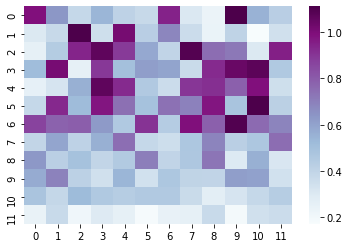

In [75]:
at_viz.layer2head()

In [82]:
clf.lang = '6-9 layers, ru->ru'
clf.test_accuracy = Accuracy()
clf.n_layers = [6, 7, 8, 9]

In [83]:
test_loader = DataLoader(test_data, batch_size=8)
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
 '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
 '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
 '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
 '6-9 layers, ru->ru: test_acc_epoch': 0.6830000281333923,
 '6-9 layers, ru->ru: test_loss': 0.5962749719619751,
 '7-11 layers, ru->ru: test_acc': 0.6420000195503235,
 '7-11 layers, ru->ru: test_acc_epoch': 0.6420000195503235,
 '7-11 layers, ru->ru: test_loss': 3.8924217224121094,
 'en->en: test_acc': 0.7149999737739563,
 'en->en: test_acc_epoch': 0.7149999737739563,
 'en->en: test_loss': 0.6548287272453308,
 'fr->fr: test_acc': 0.6949999928474426,
 'fr->fr: test_acc_epoch': 0.6949999928474426,
 'fr->f

[{'0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
  '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
  '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
  '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
  '6-9 layers, ru->ru: test_acc_epoch': 0.6830000281333923,
  '6-9 layers, ru->ru: test_loss': 0.5962749719619751,
  '7-11 layers, ru->ru: test_acc': 0.6420000195503235,
  '7-11 layers, ru->ru: test_acc_epoch': 0.6420000195503235,
  '7-11 layers, ru->ru: test_loss': 3.8924217224121094,
  'en->en: test_acc': 0.7149999737739563,
  'en->en: test_acc_epoch': 0.7149999737739563,
  'en->en: test_loss': 0.6548287272453308,
  'fr->fr: test_acc': 0.6949999928474426,
  'fr->fr: test_acc_epoch': 0.6949999928474426,
  'fr->fr: test_loss': 2.541999578475952,
  'ru->ru: test_acc': 0.625,
  'ru->ru: test_acc_epoch':

### fr-fr

In [87]:
dt_path = '/content/data/MCL-WiC/test/multilingual/test.fr-fr.data'
tag_path = '/content/data/MCL-WiC/test/test.fr-fr.gold'
df_test_wic = m_read_train_data(dt_path, tag_path, True)

df_test = df_test_wic

test_labels = df_test["tag"].tolist()

test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

test_data = mBertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
clf.lang = 'fr->fr'
clf.test_accuracy = Accuracy()

In [ ]:
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '7-11 layers, ru->ru: test_acc': 0.6420000195503235,
 '7-11 layers, ru->ru: test_acc_epoch': 0.6420000195503235,
 '7-11 layers, ru->ru: test_loss': 3.8924217224121094,
 'en->en: test_acc': 0.7149999737739563,
 'en->en: test_acc_epoch': 0.7149999737739563,
 'en->en: test_loss': 0.6548287272453308,
 'fr->fr: test_acc': 0.6949999928474426,
 'fr->fr: test_acc_epoch': 0.6949999928474426,
 'fr->fr: test_loss': 2.541999578475952,
 'ru->ru: test_acc': 0.625,
 'ru->ru: test_acc_epoch': 0.625,
 'ru->ru: test_loss': 0.7392672300338745}
--------------------------------------------------------------------------------


[{'0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '7-11 layers, ru->ru: test_acc': 0.6420000195503235,
  '7-11 layers, ru->ru: test_acc_epoch': 0.6420000195503235,
  '7-11 layers, ru->ru: test_loss': 3.8924217224121094,
  'en->en: test_acc': 0.7149999737739563,
  'en->en: test_acc_epoch': 0.7149999737739563,
  'en->en: test_loss': 0.6548287272453308,
  'fr->fr: test_acc': 0.6949999928474426,
  'fr->fr: test_acc_epoch': 0.6949999928474426,
  'fr->fr: test_loss': 2.541999578475952,
  'ru->ru: test_acc': 0.625,
  'ru->ru: test_acc_epoch': 0.625,
  'ru->ru: test_loss': 0.7392672300338745}]

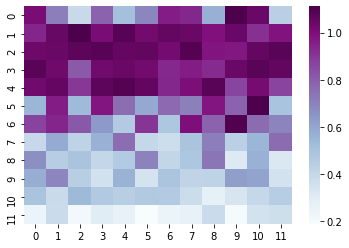

In [ ]:
test_loader = DataLoader(test_data, batch_size=1)
trained_bert = clf.model
at_viz = AnalysisAttention(test_loader, trained_bert, False)
at_viz.layer2head()

In [93]:
clf.lang = '7-11 layers, fr->fr'
clf.test_accuracy = Accuracy()
# clf.n_layers = [0, 1, 2, 3, 4, 5, 6]
# clf.n_layers = [3, 4, 5, 6, 7, 8]
# clf.n_layers = [6, 7, 8, 9]
clf.n_layers = [7, 8, 9, 10, 11]

In [94]:
test_loader = DataLoader(test_data, batch_size=8)
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
 '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
 '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
 '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
 '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
 '6-9 layers, fr->fr: test_acc': 0.7319999933242798,
 '6-9 layers, fr->fr: test_acc_epoch': 0.7319999933242798,
 '6-9 layers, fr->fr: test_loss': 0.5537999272346497,
 '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
 '6-9 lay

[{'0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
  '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
  '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
  '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
  '6-9 layers, fr->fr: test_acc': 0.7319999933242798,
  '6-9 layers, fr->fr: test_acc_epoch': 0.7319999933242798,
  '6-9 layers, fr->fr: test_loss': 0.5537999272346497,
  '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
  '6-9 layers, ru->ru: test_acc_epoch': 0.6830000281333923,
  '6-9 layers, ru->ru: test_loss': 0.5962

### ar - ar

In [147]:
dt_path = '/content/data/MCL-WiC/test/multilingual/test.ar-ar.data'
tag_path = '/content/data/MCL-WiC/test/test.ar-ar.gold'
df_test_wic = m_read_train_data(dt_path, tag_path, True)

df_test = df_test_wic

test_labels = df_test["tag"].tolist()

test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

test_data = mBertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [96]:
clf.lang = 'ar->ar'
clf.test_accuracy = Accuracy()

In [97]:
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
 '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
 '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
 '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
 '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
 '6-9 layers, fr->fr: test_acc': 0.7319999933242798,
 '6-9 layers, fr->fr: test_acc_epoch': 0.7319999933242798,
 '6-9 layers, fr->fr: test_loss': 0.5537999272346497,
 '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
 '6-9 lay

[{'0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
  '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
  '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
  '3-8 layers, ru->ru: test_loss': 0.6907534003257751,
  '6-9 layers, fr->fr: test_acc': 0.7319999933242798,
  '6-9 layers, fr->fr: test_acc_epoch': 0.7319999933242798,
  '6-9 layers, fr->fr: test_loss': 0.5537999272346497,
  '6-9 layers, ru->ru: test_acc': 0.6830000281333923,
  '6-9 layers, ru->ru: test_acc_epoch': 0.6830000281333923,
  '6-9 layers, ru->ru: test_loss': 0.5962

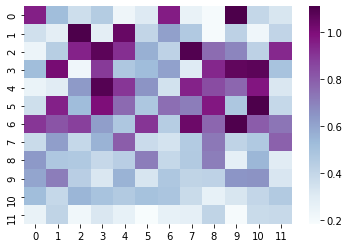

In [131]:
test_loader = DataLoader(test_data, batch_size=1)
trained_bert = clf.model
at_viz = AnalysisAttention(test_loader, trained_bert, True)
at_viz.layer2head()

In [148]:
clf.lang = '0-6 layers, ar->ar'
clf.test_accuracy = Accuracy()
clf.n_layers = [0, 1, 2, 3, 4, 5, 6]
# clf.n_layers = [3, 4, 5, 6, 7, 8]
# clf.n_layers = [6, 7, 8, 9]
# clf.n_layers = [7, 8, 9, 10, 11]

In [149]:
test_loader = DataLoader(test_data, batch_size=8)
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
 '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
 '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
 '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '3-8 layers, ar->ar: test_acc': 0.531000018119812,
 '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
 '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
 '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
 '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
 '3-8 layer

[{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
  '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
  '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
  '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '3-8 layers, ar->ar: test_acc': 0.531000018119812,
  '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
  '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
  '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
  '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
  '3-8 layers, ru->ru: test_loss': 0.690753

### zh-zh

In [150]:
dt_path = '/content/data/MCL-WiC/test/multilingual/test.zh-zh.data'
tag_path = '/content/data/MCL-WiC/test/test.zh-zh.gold'
df_test_wic = m_read_train_data(dt_path, tag_path, True)

df_test = df_test_wic

test_labels = df_test["tag"].tolist()

test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

test_data = mBertDataset(test_sentences, test_word_ranges, test_labels, MAX_TOKENS, mbert_tokenizer)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [143]:
clf.lang = 'zh->zh'
clf.test_accuracy = Accuracy()

In [144]:
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
 '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
 '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
 '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '3-8 layers, ar->ar: test_acc': 0.531000018119812,
 '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
 '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
 '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
 '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
 '3-8 layer

[{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
  '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
  '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
  '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '3-8 layers, ar->ar: test_acc': 0.531000018119812,
  '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
  '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.6518080234527588,
  '3-8 layers, ru->ru: test_acc': 0.5410000085830688,
  '3-8 layers, ru->ru: test_acc_epoch': 0.5410000085830688,
  '3-8 layers, ru->ru: test_loss': 0.690753

In [158]:
clf.lang = '7-11 layers, zh->zh'
clf.test_accuracy = Accuracy()
# clf.n_layers = [0, 1, 2, 3, 4, 5, 6]
# clf.n_layers = [3, 4, 5, 6, 7, 8]
# clf.n_layers = [6, 7, 8, 9]
clf.n_layers = [7, 8, 9, 10, 11]

In [159]:
test_loader = DataLoader(test_data, batch_size=8)
trainer.test(clf, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
 '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
 '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
 '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
 '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
 '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
 '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
 '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
 '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
 '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
 '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
 '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
 '3-8 layers, ar->ar: test_acc': 0.531000018119812,
 '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
 '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
 '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
 '3-8 layer

[{'0-6 layers, ar->ar: test_acc': 0.4970000088214874,
  '0-6 layers, ar->ar: test_acc_epoch': 0.4970000088214874,
  '0-6 layers, ar->ar: test_loss': 0.8303773403167725,
  '0-6 layers, fr->fr: test_acc': 0.5049999952316284,
  '0-6 layers, fr->fr: test_acc_epoch': 0.5049999952316284,
  '0-6 layers, fr->fr: test_loss': 0.8027026653289795,
  '0-6 layers, ru->ru: test_acc': 0.5009999871253967,
  '0-6 layers, ru->ru: test_acc_epoch': 0.5009999871253967,
  '0-6 layers, ru->ru: test_loss': 0.8481836915016174,
  '0-6 layers, zh->zh: test_acc': 0.5080000162124634,
  '0-6 layers, zh->zh: test_acc_epoch': 0.5080000162124634,
  '0-6 layers, zh->zh: test_loss': 0.7685385942459106,
  '3-8 layers, ar->ar: test_acc': 0.531000018119812,
  '3-8 layers, ar->ar: test_acc_epoch': 0.531000018119812,
  '3-8 layers, ar->ar: test_loss': 0.6897791028022766,
  '3-8 layers, fr->fr: test_acc': 0.5889999866485596,
  '3-8 layers, fr->fr: test_acc_epoch': 0.5889999866485596,
  '3-8 layers, fr->fr: test_loss': 0.651808